In [100]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import geopandas as gpd

from lib import groundwater_qc

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [101]:
# load well locations
locs_gdf = gpd.read_file(
    "/Users/dillonragar/github/tnc_webapp/data/jldp_ngen_nhdhr.gpkg", layer="wells"
)

In [130]:
# load QCd well data, as dict

directory = Path(
    "/Users/dillonragar/github/TNC_dangermond/station_data/output/gw_qc_pass"
)

files = [file for file in directory.rglob("*.parquet") if "Depth" in file.name]

gw_dfs = {}

for f in files:
    df = pd.read_parquet(f)
    stn_id = df["stn_id_dendra"].iloc[0]

    # drop utc time (DatetimeArray dtype isn't caught below for some reason)
    df.drop(columns="timestamp_utc", inplace=True)
    # unit conversion for numeric dtypes only
    # assumed that numeric data is in feet!
    df = (
        df.select_dtypes(exclude=["object", "datetime"]) * 0.3048
    )  # UNIT: FEET TO METERS
    gw_dfs[stn_id] = df

In [103]:
locs_gdf

,name,station_id_dendra,divide_id,id,toid,geometry
0,Cistern Water Tank,,cat-118,wb-118,nex-47,POINT (-2200628.557 1554053.509)
1,Cojo HQ Water Tank,,cat-49,wb-49,tnx-1000000012,POINT (-2203798.235 1551244.736)
2,Dangermond Alegria,64dbe91cd0708704d6d53d8c,cat-45,wb-45,nex-46,POINT (-2201366.767 1553047.530)
3,Dangermond Alexander Ramajal,64dbe9ce2148db3f6f481b1a,cat-43,wb-43,nex-44,POINT (-2199130.599 1558582.142)
4,Dangermond Buckhorn 1,64dbe9c755264579ef3ea324,cat-113,wb-113,nex-14,POINT (-2196921.555 1555734.107)
...,...,...,...,...,...,...
66,Santa Cruz Island Main Ranch South Well,60ca468be59e3ba96d7911d1,None,None,None,POINT (-2152727.446 1484582.407)
67,Santa Cruz Island Nursery Weather Station,63686470b055ac33a4843a58,None,None,None,POINT (-2148928.239 1482885.719)
68,Santa Cruz Island Pelican Pines,63645ca25d4311382ce55686,None,None,None,POINT (-2148837.160 1485931.333)
69,Santa Cruz Island Prsoner Well Gauge,63686563b055ac80f1843a5b,None,None,None,POINT (-2148837.160 1485931.333)


In [131]:
# get unique catchments
cats = locs_gdf["divide_id"].unique()


catchment_data = {}


for cat in cats:
    # get ids of wells in catchment
    print(f"catchment: {cat}")
    sub = locs_gdf[locs_gdf["divide_id"] == cat]
    # print(f"loc: {sub['name']}")

    ids_arr = sub["station_id_dendra"].values
    filt_ids = ids_arr[ids_arr != ""].tolist()
    print(f"stns in catchment: {filt_ids}")

    stn_df_list = []

    # get list of dfs for each catchment
    for id in filt_ids:
        if id in gw_dfs:  # some stations in a catchment have no data
            stn_df_list.append(gw_dfs[id])

    catchment_data[cat] = stn_df_list

catchment: cat-118
stns in catchment: ['64dbe9c82148dbfa66481b12']
catchment: cat-49
stns in catchment: []
catchment: cat-45
stns in catchment: ['64dbe91cd0708704d6d53d8c']
catchment: cat-43
stns in catchment: ['64dbe9ce2148db3f6f481b1a', '64dbe9ce5c0d5f46af694aa5']
catchment: cat-113
stns in catchment: ['64dbe9c755264579ef3ea324', '64dbe9c780818732a0c9038b']
catchment: cat-26
stns in catchment: ['64dbe9c8d07087cecfd53d8e']
catchment: cat-66
stns in catchment: ['64dbe9c880818761a2c9038d']
catchment: cat-69
stns in catchment: ['64dbe9ce02096974eea07382']
catchment: cat-31
stns in catchment: ['64dbe9c8d070876630d53d90', '64dbe9c92148db2146481b14', '64dbe9ca5c0d5f0fd8694a9f']
catchment: cat-30
stns in catchment: ['64d3cbe75c0d5f2b526942c8', '64dbe9c902096994b4a0737c', '64dbe9c9f1438d459a4dd9cb']
catchment: cat-56
stns in catchment: ['64dbe9ca02096942dfa0737e']
catchment: cat-120
stns in catchment: ['64dbe9ca5c0d5f04d5694aa1']
catchment: cat-65
stns in catchment: ['64dbe9ca552645785b3ea326

In [133]:
catchment_combined = {}

for cat in cats:
    if catchment_data[cat]:
        new_dfs = []
        # print(catchment_data[cat])
        for df in catchment_data[cat]:
            # round to 5min, so all data is on common index
            df.index = df.index.round(freq="5min")
            new_dfs.append(df)

        df_out = pd.concat(new_dfs)

        # df_out.drop(columns=["stn_id_dendra", "va", "q"], inplace=True)
        df_out = df_out.resample("D").mean()
        print(df_out)
        # df_out = df_out.asfreq("5min")
        # df_out.index = df.index.round("5min")

        catchment_combined[cat] = df_out

                 DangermondEscondido2_Depth_to_Groundwater  \
timestamp_local                                              
2020-11-04                                       54.220451   
2020-11-05                                       54.254499   
2020-11-06                                       54.340165   
2020-11-07                                       54.346350   
2020-11-08                                       54.313324   
...                                                    ...   
2023-06-11                                             NaN   
2023-06-12                                             NaN   
2023-06-13                                             NaN   
2023-06-14                                             NaN   
2023-06-15                                             NaN   

                 DangermondEscondido5_Depth_to_Groundwater  
timestamp_local                                             
2020-11-04                                             NaN  
2020-11-05

In [134]:
collapsed_df

,DangermondTinta5_Depth_to_Groundwater,catchment_mean
timestamp_local,,
2009-10-28,135.174467,135.174467
2009-10-29,135.117184,135.117184
2009-10-30,135.100298,135.100298
2009-10-31,135.222818,135.222818
2009-11-01,135.335091,135.335091
...,...,...
2011-05-29,168.210065,168.210065
2011-05-30,168.085808,168.085808
2011-05-31,168.096204,168.096204


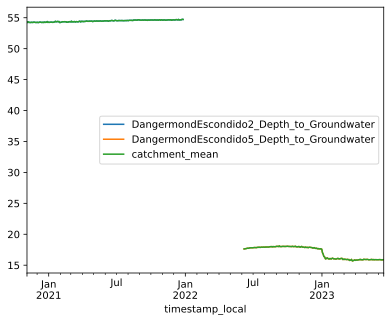

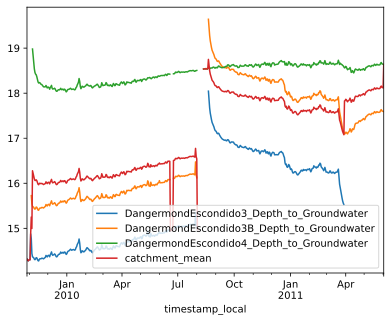

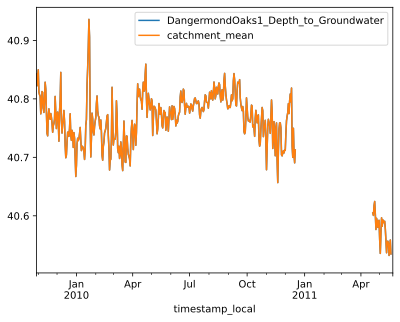

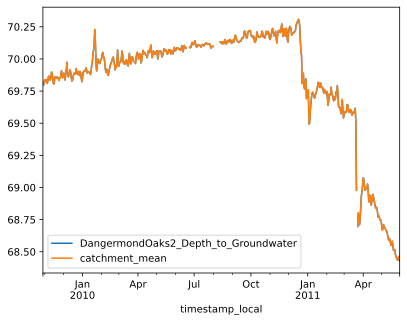

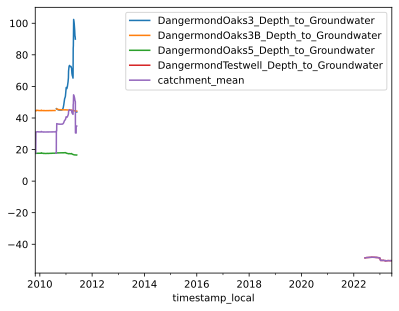

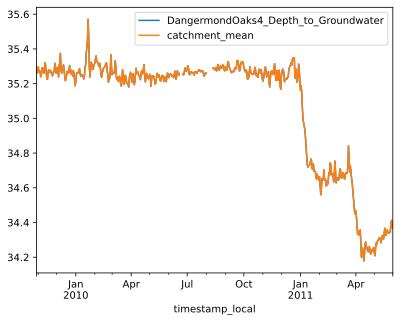

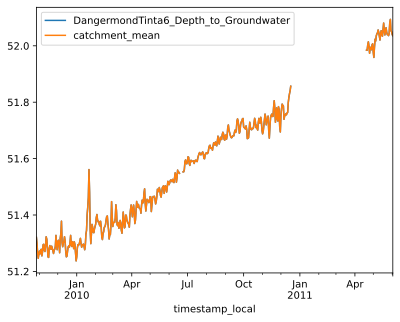

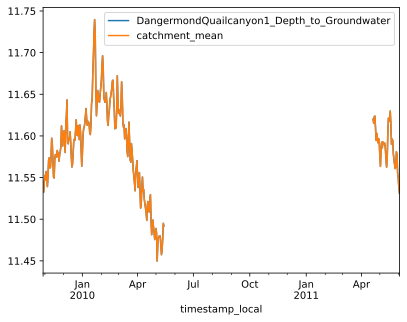

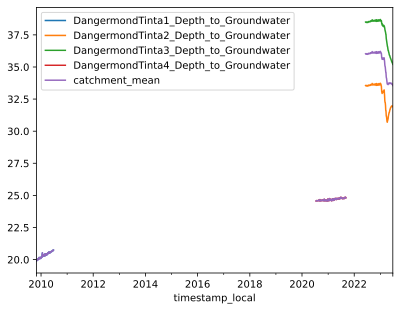

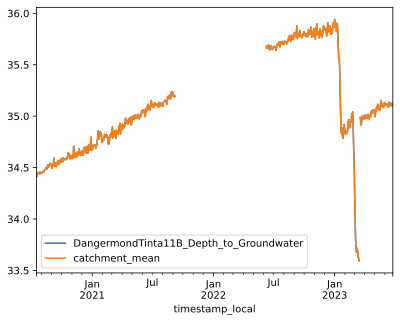

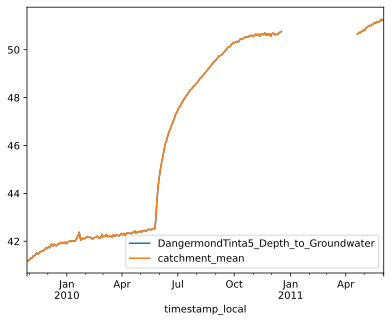

In [136]:
for cat in cats:
    if cat in catchment_combined:
        df = catchment_combined[cat]

        # Combine duplicate rows, keeping the first non-null value for each column
        collapsed_df = df.groupby(df.index).apply(
            lambda group: group.ffill().bfill().iloc[0]
        )
        collapsed_df["catchment_mean"] = collapsed_df.mean(axis=1)

        collapsed_df.plot()

        # reassign station id
        file_name = f"{cat}_gw_delta_mean_daily_meters.parquet"
        collapsed_df.to_parquet(f"./output/gw_catchment_mean_daily/{file_name}")